In [1]:
#!/usr/bin/env python
# coding: utf-8
import itertools
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential


#忽略警告
import warnings
warnings.filterwarnings("ignore")
#如果没有这个目录，则创建这个目录
if not os.path.isdir('result'):
    os.mkdir('result')

## arima模型

In [2]:
df = pd.read_csv("债券数据.csv")   
#读取数据
df.head()#查看数据前5行

,净值日期,单位净值,累计净值,日增长率,申购状态,赎回状态,分红送配,国债收益率,国债收益率.1,日收益率
0,2023/1/3,100.3105,1.0031,0.04%,场内买入,场内卖出,NaN,1.601,0.021347,0.04
1,2023/1/4,100.3198,1.0032,0.01%,场内买入,场内卖出,NaN,1.601,0.021347,0.01
2,2023/1/5,100.2582,1.0026,-0.06%,场内买入,场内卖出,NaN,1.601,0.021347,-0.06
3,2023/1/6,100.2020,1.0020,-0.06%,场内买入,场内卖出,NaN,1.601,0.021347,-0.06
4,2023/1/9,100.1715,1.0017,-0.03%,场内买入,场内卖出,NaN,1.601,0.021347,-0.03


In [3]:
#获取values列名数据
data=df['日收益率']
date=df['净值日期'] #获取date列日期数据

In [4]:
#定义稳定性检验函数
def adf_val(ts, ts_title):
    '''
    ts: 时间序列数据，Series类型
    ts_title: 时间序列图的标题名称，字符串
    '''
    # 稳定性（ADF）检验
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(ts)

    name = ['adf', 'pvalue', 'usedlag','nobs', 'critical_values', 'icbest']
    values = [adf, pvalue, usedlag, nobs,critical_values, icbest]
    print(list(zip(name, values)))

    return adf, pvalue, critical_values,
    # 返回adf值、adf的p值、三种状态的检验值

In [5]:
#白噪声检验也称为纯随机性检验，当数据是纯随机数据时，再对数据进行分析就没有任何意义了，所以拿到数据后最好对数据进行一个纯随机性检验。
def acorr_val(ts):
    '''
    # 白噪声（随机性）检验
    ts: 时间序列数据，Series类型
    返回白噪声检验的P值
    '''
    lbvalue, pvalue = acorr_ljungbox(ts, lags=1)  # 白噪声检验结果
    return lbvalue, pvalue



def tsplot(y, lags=None, figsize=(15, 8)):
    fig = figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax=ts_ax)
    ts_ax.set_title('origin  data')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    #自相关（Autocorrelation）： 对一个时间序列，现在值与其过去值的相关性。如果相关性为正，则说明现有趋势将继续保持。
    plot_acf(y, lags=lags, ax=acf_ax)
    #可以度量现在值与过去值更纯正的相关性
    plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()

    fig.tight_layout()
    fig.savefig('result/ACF_PACF.png')#图片保存路径
    fig.show()

    return ts_ax, acf_ax, pacf_ax

In [6]:
#获取values列名的数据，并转为float32类型数据
ts_data = data.astype('float32')

In [7]:
#平稳性检验
adf1, pvalue1, critical_values1 = adf_val(ts_data, 'raw time series') #对原数据进行平稳性判断
print('adf',adf1)
print('pvalue1',pvalue1)
print('critical_values',critical_values1)
#结果显示，adf结果为-2.2394..， 不小于critical_values的三个level的统计值。pvalue也不接近于0 的，所以是不平稳的，所以需要做一阶差分
#若p值远小于0.01，认为该时间序列是平稳的

#白噪声检验
aco=acorr_val(ts_data)
print('aco',aco)


[('adf', -10.328860879094893), ('pvalue', 2.877553067737513e-18), ('usedlag', 0), ('nobs', 170), ('critical_values', {'1%': -3.469413468959902, '5%': -2.8786964197028295, '10%': -2.5759166089965397}), ('icbest', -759.2146498030442)]
adf -10.328860879094893
pvalue1 2.877553067737513e-18
critical_values {'1%': -3.469413468959902, '5%': -2.8786964197028295, '10%': -2.5759166089965397}
aco ('lb_stat', 'lb_pvalue')


这个结果是进行ARIMA模型的平稳性检验后的输出。ARIMA模型要求时间序列数据是平稳的，因此平稳性检验是非常重要的步骤之一，以确保模型的有效性。  

让我们逐个分析上面显示的这些结果：  

1. ADF统计量（adf）：ADF（Augmented Dickey-Fuller）统计量用于检验时间序列数据是否平稳。在这里，ADF统计量的值为-10.328860879094893。一般来说，如果ADF统计量的值比临界值更负，那么我们可以拒绝原假设，即数据是非平稳的。在这种情况下，ADF统计量的值明显小于临界值，表明数据是平稳的。  

2. p-值（pvalue）：p-值是用来判断在给定的置信水平下是否可以拒绝原假设的。在这里，p-值非常接近于零，精确到2.877553067737513e-18，这表示在任何合理的置信水平下，我们都可以拒绝原假设，即数据是非平稳的。因此，这个p-值支持了ADF统计量的结论，即数据是平稳的。  

3. 用于估计滞后阶数的滞后阶数（usedlag）：在这个情况下，使用了0个滞后阶数来估计ADF统计量。  

4. 观测数量（nobs）：在平稳性检验中使用的观测数量为170。  

5. 临界值（critical_values）：这是关键的部分。它列出了在不同置信水平下的临界值。在这里，我们可以看到在1%、5%和10%的置信水平下的临界值分别为-3.469413468959902、-2.8786964197028295和-2.5759166089965397。由于ADF统计量的值远远低于这些临界值，因此我们可以得出数据是平稳的结论。  

总结：根据ADF统计量的值、极低的p-值和临界值的比较，可以得出结论，你的时间序列数据在给定的置信水平下是平稳的。这是进行ARIMA建模的前提条件之一，因此你可以继续进行ARIMA模型的参数选择和拟合。

(<AxesSubplot:title={'center':'origin  data'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

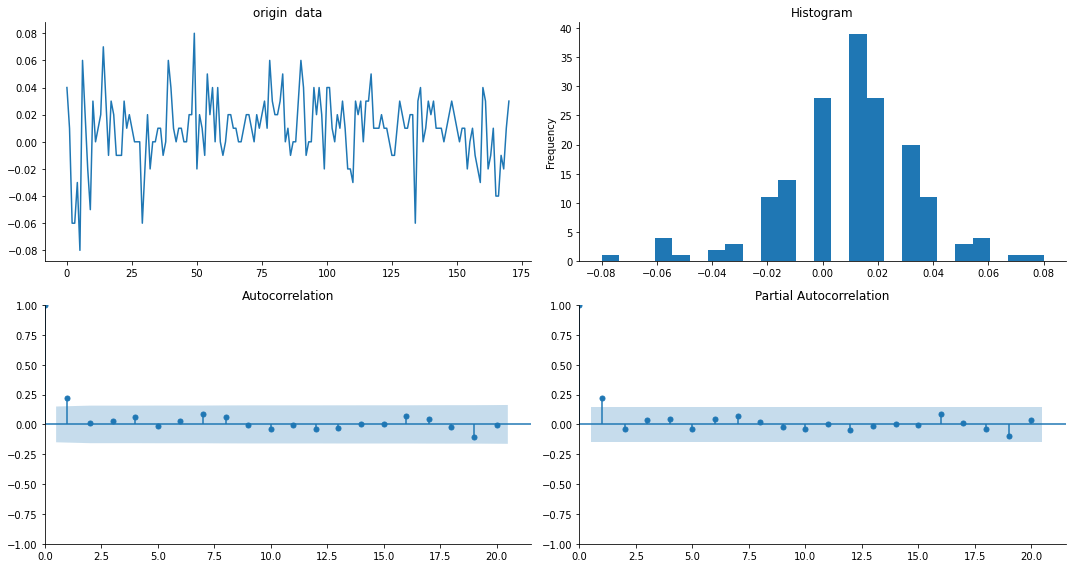

In [8]:
##显示原数据（未差分）的自相关ACF和偏自相关PACF
tsplot(ts_data, lags=20)

In [9]:
#下面这段用于寻找arima参数，若不会用可不用
#确定ARIMA的p、q、d参数，
#一种方式可以根据上述的ACF图和PACF图来确定，但通常由于主观性，不好确定；
#另一种方式可以用个AIC或者BIC指标进行选取参数，这里用AIC进行确定，采用网格搜索进行寻参

# #AIC和BIC计算最好的pdq值
q_arima = range(0, 3)#定义q值的范围
d_arima = 0 #d值为差分项，若原数据平稳不需要进行差分则d=0,否则d为原始数据差分稳定的阶数
p_arima = range(0, 3)#定义p值的范围
AIC_arima = [] #定义AIC列表存储AIC值
ARIMAX_model = []#定义模型参数列表存储参数值
#循环各组参数来试验哪组参数比较好
pdqs = [(x[0], d_arima, x[1]) for x in list(itertools.product(p_arima, q_arima))]

from statsmodels.tsa.arima.model import ARIMA


for pdq in pdqs:
    mod =ARIMA(ts_data, order=pdq)
    results = mod.fit()
    print('ARIMA{} - AIC:{}'.format(pdq, results.aic))
    AIC_arima.append(results.aic)
    ARIMAX_model.append(pdq)
print('AIC_arima')
print(AIC_arima)

index=AIC_arima.index(min(AIC_arima))
order = ARIMAX_model[index]
print('order num',order)

ARIMA(0, 0, 0) - AIC:-778.0340855864354
ARIMA(0, 0, 1) - AIC:-785.2629970257262
ARIMA(0, 0, 2) - AIC:-783.2900016064832
ARIMA(1, 0, 0) - AIC:-784.9726363348259
ARIMA(1, 0, 1) - AIC:-783.2892422853027
ARIMA(1, 0, 2) - AIC:-781.3877657365651
ARIMA(2, 0, 0) - AIC:-783.250156447805
ARIMA(2, 0, 1) - AIC:-781.0321770873148
ARIMA(2, 0, 2) - AIC:-779.5396583889353
AIC_arima
[-778.0340855864354, -785.2629970257262, -783.2900016064832, -784.9726363348259, -783.2892422853027, -781.3877657365651, -783.250156447805, -781.0321770873148, -779.5396583889353]
order num (0, 0, 1)


通过ARIMA模型的阶数选择，得到了ARIMA(2, 0, 2)模型，同时给出了AIC（Akaike信息准则）值为-779.5396583889353。这个结果提供了一个在ARIMA模型中选择阶数的线索。  

在ARIMA模型中，通常使用AIC或BIC（Bayesian信息准则）等信息准则来帮助选择模型的阶数。这些准则的目标是在模型的拟合能力和复杂性之间找到一个平衡点，以便选择最佳的模型。较低的AIC或BIC值表示模型更好。  

在这里，ARIMA(2, 0, 2)的AIC值为-779.54，这是一个负值，表示这个模型相对较好。通常情况下，你可以考虑选择具有最低AIC或BIC值的模型作为最终的ARIMA模型。  

因此，ARIMA(2, 0, 2)是一个潜在的候选模型，你可以继续进行模型的拟合和评估，然后根据实际的拟合质量来决定是否采用这个模型。  

In [10]:

order=(2,0,2)#有时候寻参出来的参数也不一定能用，可能需要调一下（出错情况下）

# # 构建训练数据
ndata=np.array(ts_data).reshape(-1,1)#转换数据格式为array类型（方便取值操作）
#划分训练集和测试集
train_len=int(len(ndata)*0.80)#取80%数据作为训练集
train_ar = ndata[:train_len,:]#取数据[行或行区间(:),列或列区间(:)]
test_ar = ndata[train_len:,:]

history = [x for x in train_ar]
print(type(history))
pre = list()

#训练ARIMA模型
for t in range(len(test_ar)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()#模型训练
    output = model_fit.forecast()#模型预测
    yhat = output[0]
    pre.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

#数据类型转换
pre=np.array(pre)

<class 'list'>
predicted=0.014485, expected=0.040000
predicted=0.020768, expected=0.000000
predicted=0.007779, expected=0.010000
predicted=0.010760, expected=0.030000
predicted=0.014861, expected=0.020000
predicted=0.012180, expected=0.030000
predicted=0.014547, expected=0.010000
predicted=0.010229, expected=0.010000
predicted=0.010755, expected=0.010000
predicted=0.010926, expected=0.000000
predicted=0.008885, expected=0.010000
predicted=0.011199, expected=0.020000
predicted=0.013043, expected=0.030000
predicted=0.014769, expected=0.020000
predicted=0.012325, expected=0.010000
predicted=0.010474, expected=0.000000
predicted=0.008894, expected=0.010000
predicted=0.011438, expected=0.010000
predicted=0.011194, expected=-0.020000
predicted=0.004738, expected=0.000000
predicted=0.009766, expected=0.010000
predicted=0.011480, expected=-0.010000
predicted=0.006595, expected=-0.020000
predicted=0.004785, expected=-0.030000
predicted=0.001951, expected=0.040000
predicted=0.018248, expected=0.

在Python中，可以使用不同的方法来判断时间序列模型的好坏以及评估模型的性能。以下是一些常见的用于评估时间序列模型的指标和方法：

1. 均方根误差（RMSE）和平均绝对误差（MAE）：
   - RMSE和MAE是用于衡量模型预测值与真实值之间差异的指标。较低的RMSE和MAE值表示模型的预测较为准确。你可以使用Python中的NumPy和Scikit-Learn库来计算这些指标。

2. 平均百分比误差（MAPE）：
   - MAPE是一个百分比误差指标，它可以告诉你模型的预测值与真实值相对误差的大小。更低的MAPE值表示更准确的模型预测。计算MAPE时，通常需要注意避免分母为零的情况。

3. 残差图：
   - 绘制残差图可以帮助你可视化模型的性能。如果残差在零附近均匀分布，表示模型的拟合较好。你可以使用Matplotlib库来绘制残差图。

4. Q-Q图（Quantile-Quantile图）：
   - Q-Q图用于检查模型的残差是否符合正态分布。如果点在一条直线上，那么残差可以认为是近似正态分布的。你可以使用SciPy库中的`probplot`函数来绘制Q-Q图。

5. 自相关图（ACF）和偏自相关图（PACF）：
   - ACF和PACF图用于检查模型的残差是否存在自相关性。如果自相关和偏自相关值在阈值内，则表示模型的残差是随机的。你可以使用Statsmodels库来绘制这些图。

6. 拟合优度指标（Goodness of Fit Metrics）：
   - 除了上述指标之外，还可以使用其他拟合优度指标，如R-squared、信息准则（AIC、BIC）、残差平方和（SSR）等来评估模型的性能。

下面是一个示例代码片段，演示如何使用Python来计算和可视化一些常见的模型评估指标：


In [11]:

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 真实值和预测值
true_values = test_ar
predicted_values = pre

# 计算RMSE和MAE
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
mae = mean_absolute_error(true_values, predicted_values)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


RMSE: 0.0200888101512648
MAE: 0.015154417138121356


根据得到的RMSE和MAE的值，可以得出以下结论：

1. RMSE（均方根误差）的值为0.0201，这表示模型的预测值与真实值之间的均方根误差很小，这是一个很好的迹象。较小的RMSE值表明模型的预测性能相对较好。

2. MAE（平均绝对误差）的值为0.0152，这也是一个很小的值。MAE衡量了模型的预测值与真实值之间的平均绝对误差。较小的MAE值表明模型的预测在平均水平上相对准确。

综合来看，根据RMSE和MAE的值，你的模型似乎具有良好的预测性能，能够很好地拟合和预测时间序列数据。当然，在实际应用中，还应该考虑领域知识和其他评估指标来综合评估模型的性能。此外，你还可以通过绘制残差图、Q-Q图等来进一步评估模型的残差性质和拟合情况。

In [12]:
data = ts_data

In [13]:
forecast_steps = 30  # 要预测未来的个数
forecast = model_fit.forecast(steps=forecast_steps)

In [14]:
forecast

array([0.00760481, 0.00566734, 0.00650627, 0.00690791, 0.00728121,
       0.00758942, 0.00784817, 0.00806486, 0.00824639, 0.00839846,
       0.00852586, 0.00863258, 0.00872198, 0.00879688, 0.00885962,
       0.00891217, 0.0089562 , 0.00899309, 0.00902399, 0.00904987,
       0.00907155, 0.00908972, 0.00910494, 0.00911768, 0.00912836,
       0.00913731, 0.0091448 , 0.00915108, 0.00915634, 0.00916075])

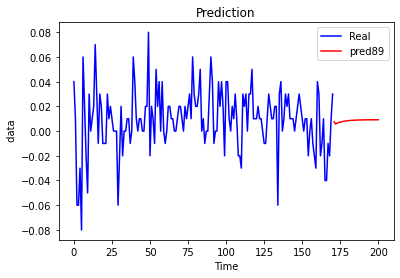

In [15]:
x1 = range(len(data))
x2 = range(len(data),len(data)+len(forecast))

plt.plot(x1,data, color = 'blue', label = 'Real')
plt.plot(x2,forecast, color = 'red', label = 'pred89')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel(' data')
plt.legend()
plt.show()

## 移动平均

In [ ]:
train_len=int(len(ndata)*0.80)#取80%数据作为训练集
train_ar = ndata[:train_len,:]#取数据[行或行区间(:),列或列区间(:)]
test_ar = ndata[train_len:,:]

history = [x for x in train_ar]
print(type(history))
pre = list()

In [20]:
def moving_average(data, window_size):
    """
    计算移动平均值

    参数:
    data (list或numpy数组): 输入时间序列数据
    window_size (int): 移动窗口的大小

    返回:
    list: 移动平均值序列
    """
    moving_averages = []
    
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        average = np.mean(window)
        moving_averages.append(average)
    
    return moving_averages

# 示例数据
data = train_ar

# 设置移动窗口大小
window_size = 7

# 计算移动平均值
averages = moving_average(data, window_size)

# 输出移动平均值
print("移动平均值序列:", averages[:35])

移动平均值序列: [-0.017142858, -0.02, -0.024285713, -0.02285714, -0.01, -0.0057142857, 0.0071428567, 0.0014285712, 0.008571429, 0.015714286, 0.02142857, 0.02142857, 0.024285713, 0.02142857, 0.017142856, 0.0057142857, 0.0057142857, 0.008571428, 0.0071428567, 0.0057142857, 0.0071428567, 0.008571428, 0.01, -0.0028571428, -0.0071428567, -0.0071428563, -0.011428571, -0.011428571, -0.011428571, -0.01, 0.0, 0.0014285714, -0.0014285714, 0.01, 0.015714286]


## 二次指数平滑算法

In [57]:
# 一次指数平滑法
def one_exponential_smoothing(data, alpha):
    smoothed_data = [data[0]]  # 初始值等于第一个数据点
    for t in range(1, len(data)):
        smoothed_data.append(alpha * data[t] + (1 - alpha) * smoothed_data[t - 1])
    return smoothed_data

# 二次指数平滑法
def two_exponential_smoothing(data, alpha, beta, n_forecast):
    m = len(data)
    # 计算一次平滑
    level1 = one_exponential_smoothing(data, alpha)
    
    # 计算二次平滑
    level2 = one_exponential_smoothing(level1, alpha)
    trend = [beta * (level1[t] - level2[t]) + (1 - beta) * (level2[t - 1] if t > 0 else 0) for t in range(m)]
    
    # 预测未来n_forecast个时间点的值
    forecast = []
    for t in range(m, m + n_forecast):
        forecast.append(level1[-1] + (t - m + 1) * trend[-1])
    
    return forecast

# 示例数据（替换为您的数据）
data = df["日收益率"][:136]

# 一次指数平滑参数
alpha = 0.2

# 二次指数平滑参数
beta = 0.1

# 预测未来30天的值
n_forecast = 35

forecast2 = two_exponential_smoothing(data, alpha, beta, n_forecast)

print("二次指数平滑法预测未来{}天的值:".format(n_forecast))
print(forecast2)

二次指数平滑法预测未来35天的值:
[0.013915450222467426, 0.022173936785117025, 0.030432423347766625, 0.038690909910416224, 0.04694939647306583, 0.05520788303571542, 0.06346636959836502, 0.07172485616101462, 0.07998334272366422, 0.08824182928631383, 0.09650031584896342, 0.10475880241161302, 0.11301728897426262, 0.12127577553691221, 0.12953426209956181, 0.13779274866221142, 0.14605123522486102, 0.15430972178751062, 0.16256820835016023, 0.17082669491280983, 0.1790851814754594, 0.187343668038109, 0.1956021546007586, 0.2038606411634082, 0.21211912772605782, 0.22037761428870742, 0.22863610085135702, 0.2368945874140066, 0.2451530739766562, 0.2534115605393058, 0.2616700471019554, 0.269928533664605, 0.2781870202272546, 0.2864455067899042, 0.2947039933525538]


## 三次指数平滑

未来30个时间点的预测值:
136    0.017403
137    0.007427
138    0.028326
139    0.022869
140    0.016507
141    0.012897
142    0.025608
143    0.022844
144    0.018062
145    0.024693
146    0.003862
147    0.019642
148    0.018640
149    0.008664
150    0.029563
151    0.024106
152    0.017744
153    0.014134
154    0.026845
155    0.024081
156    0.019299
157    0.025930
158    0.005099
159    0.020879
160    0.019877
161    0.009901
162    0.030800
163    0.025343
164    0.018981
165    0.015371
dtype: float64


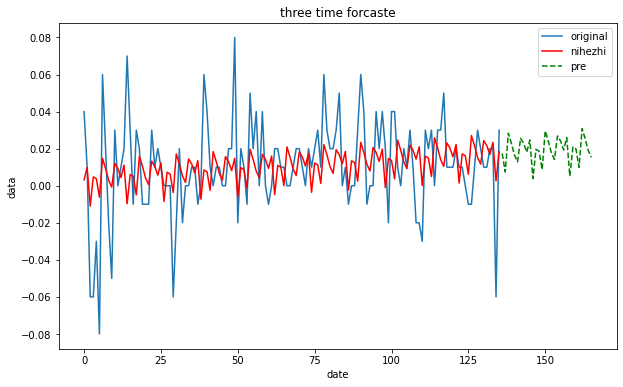

In [58]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 三次指数平滑
exponential_smoothing = sm.tsa.ExponentialSmoothing(data, trend='add', seasonal='add', seasonal_periods=12)
model = exponential_smoothing.fit()

# 预测未来时间点的值
forecast_periods = 30  # 预测未来30个时间点
forecast3 = model.forecast(steps=forecast_periods)

# 打印预测结果
print("未来{}个时间点的预测值:".format(forecast_periods))
print(forecast3)

# 可视化原始数据和预测结果
plt.figure(figsize=(10, 6))
plt.plot(data, label='original')#原始数据
plt.plot(model.fittedvalues, label='nihezhi', color='red')#拟合值
plt.plot(forecast, label='pre', linestyle='--', color='green')#预测值
plt.legend()
plt.title('three time forcaste')
plt.xlabel('date')
plt.ylabel('data')
plt.show()

## Vasicek模型

In [40]:
df[:136]

,净值日期,单位净值,累计净值,日增长率,申购状态,赎回状态,分红送配,国债收益率,国债收益率.1,日收益率
0,2023/1/3,100.3105,1.0031,0.04%,场内买入,场内卖出,NaN,1.601,0.021347,0.04
1,2023/1/4,100.3198,1.0032,0.01%,场内买入,场内卖出,NaN,1.601,0.021347,0.01
2,2023/1/5,100.2582,1.0026,-0.06%,场内买入,场内卖出,NaN,1.601,0.021347,-0.06
3,2023/1/6,100.2020,1.0020,-0.06%,场内买入,场内卖出,NaN,1.601,0.021347,-0.06
4,2023/1/9,100.1715,1.0017,-0.03%,场内买入,场内卖出,NaN,1.601,0.021347,-0.03
...,...,...,...,...,...,...,...,...,...,...
131,2023/7/20,101.6497,1.0165,0.01%,场内买入,场内卖出,NaN,1.601,0.021347,0.01
132,2023/7/21,101.6685,1.0167,0.02%,场内买入,场内卖出,NaN,1.601,0.021347,0.02
133,2023/7/24,101.6885,1.0169,0.02%,场内买入,场内卖出,NaN,1.601,0.021347,0.02
134,2023/7/25,101.6256,1.0163,-0.06%,场内买入,场内卖出,NaN,1.601,0.021347,-0.06


In [51]:
# 使用Vasicek模型生成随机利率路径
def vasicek_interest_rate_simulation(df, kappa, theta, sigma, T, n):
    np.random.seed(0)
    
    # 初始化参数
    r0 = df['日收益率'].iloc[-1]  # 使用最后一个观测值作为初始利率
    dt = T / n  # 时间步长
    rates = [r0]
    
    for i in range(n):
        dr = kappa * (theta - rates[-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
        r_next = max(rates[-1] + dr, 0)  # 利率不能为负数
        rates.append(r_next)
    
    return rates

In [55]:
# 模拟未来利率路径
T = 1  # 模拟的时间期限（以年为单位）
n = 30  # 模拟的时间步数
kappa = 0.2  # 调整风险回归速度
theta = 0.04  # 调整长期均衡利率
sigma = 0.02  # 调整利率波动率

simulated_rates = vasicek_interest_rate_simulation(df, kappa, theta, sigma, T, n)

In [56]:
len(simulated_rates)

31

In [64]:
forecast3.values

array([0.01740269, 0.00742732, 0.02832618, 0.02286887, 0.01650723,
       0.01289704, 0.02560839, 0.02284391, 0.01806217, 0.02469256,
       0.00386175, 0.01964207, 0.01863971, 0.00866434, 0.02956321,
       0.0241059 , 0.01774426, 0.01413406, 0.02684541, 0.02408093,
       0.01929919, 0.02592959, 0.00509877, 0.0208791 , 0.01987674,
       0.00990137, 0.03080023, 0.02534292, 0.01898128, 0.01537109])

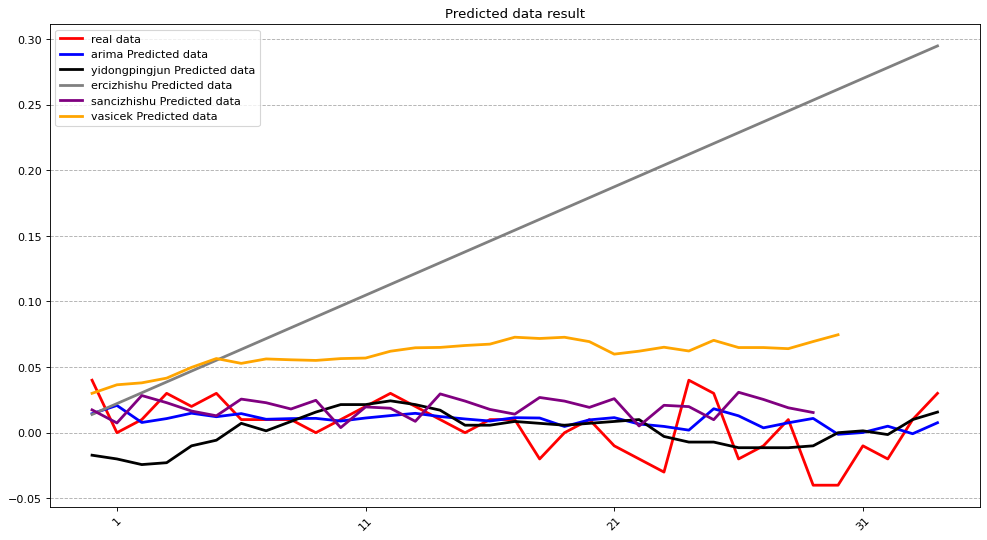

In [67]:
#显示预测结果
fig = figure(figsize=(15, 8), dpi=80)

plt.plot(test_ar, label="real data", color='r',lw=2.5)  #真实值
plt.plot(pre, label="arima Predicted data", color='blue',lw=2.5)  #arima模型预测值
plt.plot(averages[:35], label="yidongpingjun Predicted data", color='black',lw=2.5)  #移动平均
plt.plot(forecast2, label="ercizhishu Predicted data", color='gray',lw=2.5)  #二次指数
plt.plot(forecast3.values, label="sancizhishu Predicted data", color='purple',lw=2.5)  #三次指数
plt.plot(simulated_rates, label="vasicek Predicted data", color='orange',lw=2.5)  #vasicek

plt.title("Predicted data result")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(pre),10),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.show()

## 红色的曲线为真实值，其他曲线分别为不同模型的预测结果。通过和真实值进行比较，可以排除二次指数模型和vasicek模型（误差大）。其他模型拟合效果相差不大，最终选择效果最好的arima模型进行预测。

## 选择上面生成的arima模型预测未来利率

In [68]:
forecast_steps = 30  # 要预测未来的个数
forecast = model_fit.forecast(steps=forecast_steps)

In [69]:
forecast

array([0.00760481, 0.00566734, 0.00650627, 0.00690791, 0.00728121,
       0.00758942, 0.00784817, 0.00806486, 0.00824639, 0.00839846,
       0.00852586, 0.00863258, 0.00872198, 0.00879688, 0.00885962,
       0.00891217, 0.0089562 , 0.00899309, 0.00902399, 0.00904987,
       0.00907155, 0.00908972, 0.00910494, 0.00911768, 0.00912836,
       0.00913731, 0.0091448 , 0.00915108, 0.00915634, 0.00916075])

要比较投资浮动利率债券和国债，首先需要将浮动利率债券的未来利率折现到现在的价值。可以使用以下公式来计算：

\[PV = \frac{FV}{(1 + r_1)(1 + r_2)\ldots(1 + r_n)}\]

其中：
- PV 是现在的价值
- FV 是未来的价值（债券的面值，这里是100）
- \(r_1, r_2, \ldots, r_n\) 是未来每个期间的利率

在这种情况下，未来一个月的浮动利率为给定的列表中的值。同时，国债的利率是0.021347。

让我们计算未来一个月内浮动利率债券的现值，并与国债利率进行比较。

首先，计算每个月的折现因子：
\[DF = \frac{1}{(1 + r_1)(1 + r_2)\ldots(1 + r_n)}\]

然后，将每个月的折现因子与100（债券的面值）相乘，以计算出每个月的现值。最后，获得浮动利率债券的总现值。


In [114]:
def Bond_decision(forecast,guozhai_interest,days):
    PV = 100*forecast[days]/(1+forecast[days])**-days
    PV_2 = 100*guozhai_interest
    if (PV < PV_2):
        print('在%d天时，适和抛出债券，购买国债/储蓄' % (days))
    else:
        print('在%d天时，适和保持债券' % (days))

In [115]:
Bond_decision(forecast,0.021347,29)

在29天时，适和抛出债券，购买国债/储蓄
